In [22]:
import warnings
warnings.filterwarnings('ignore')
import pickle
import numpy as np
import pandas as pd
import json
#from textblob import TextBlob
import nltk
from scipy import spatial
#import torch
# import spacy
# en_nlp = spacy.load('en')

## Convert Json to Pandas Dataframe

In [23]:
train = pd.read_json("train-v2.0.json")

In [24]:
valid = pd.read_json("dev-v2.0.json")

In [25]:
train.shape, valid.shape

((442, 2), (35, 2))

In [26]:
train

,version,data
0,v2.0,"{'title': 'Beyoncé', 'paragraphs': [{'qas': [{..."
1,v2.0,"{'title': 'Frédéric_Chopin', 'paragraphs': [{'..."
2,v2.0,{'title': 'Sino-Tibetan_relations_during_the_M...
3,v2.0,"{'title': 'IPod', 'paragraphs': [{'qas': [{'qu..."
4,v2.0,{'title': 'The_Legend_of_Zelda:_Twilight_Princ...
...,...,...
437,v2.0,"{'title': 'Infection', 'paragraphs': [{'qas': ..."
438,v2.0,"{'title': 'Hunting', 'paragraphs': [{'qas': [{..."
439,v2.0,"{'title': 'Kathmandu', 'paragraphs': [{'qas': ..."
440,v2.0,"{'title': 'Myocardial_infarction', 'paragraphs..."


In [27]:
train.iloc[3,1]['paragraphs']

[{'qas': [{'question': 'Which company produces the iPod?',
    'id': '56cc55856d243a140015ef0a',
    'answers': [{'text': 'Apple', 'answer_start': 105}],
    'is_impossible': False},
   {'question': 'When was the original iPod released?',
    'id': '56cc55856d243a140015ef0b',
    'answers': [{'text': 'October 23, 2001', 'answer_start': 147}],
    'is_impossible': False},
   {'question': 'How many different types of iPod are currently available?',
    'id': '56cc55856d243a140015ef0c',
    'answers': [{'text': 'three', 'answer_start': 302}],
    'is_impossible': False},
   {'question': 'What kind of device is the iPod?',
    'id': '56cc55856d243a140015ef0d',
    'answers': [{'text': 'portable media players', 'answer_start': 22}],
    'is_impossible': False},
   {'question': 'The iPod Touch uses what kind of interface?',
    'id': '56cc55856d243a140015ef0e',
    'answers': [{'text': 'touchscreen', 'answer_start': 400}],
    'is_impossible': False},
   {'question': 'In what year was the fi

In [28]:
# valid.iloc[1,0]['paragraphs'][0]

In [29]:
'''
Creating a dataframe containing context,questions and answers
'''
contexts = []
questions = []
answers_text = []
answers_start = []
for i in range(train.shape[0]):
    topic = train.iloc[i,1]['paragraphs']
    try:
        for sub_para in topic:
            for q_a in sub_para['qas']:
                questions.append(q_a['question'])
                answers_start.append(q_a['answers'][0]['answer_start'])
                answers_text.append(q_a['answers'][0]['text'])
                contexts.append(sub_para['context']) 
    except:
        # To handle unforseen cases that came up during processing
        answers_start.append("NULL")
        answers_text.append("NULL")
        contexts.append("NULL")
        continue
df = pd.DataFrame({"context":contexts, "question": questions, "answer_start": answers_start, "text": answers_text})

In [30]:
df

,context,question,answer_start,text
0,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,269,in the late 1990s
1,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,207,singing and dancing
2,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,526,2003
3,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,166,"Houston, Texas"
4,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,276,late 1990s
...,...,...,...,...
48148,"Kathmandu Metropolitan City (KMC), in order to...",With what Belorussian city does Kathmandu have...,476,Minsk
48149,"Kathmandu Metropolitan City (KMC), in order to...",In what year did Kathmandu create its initial ...,199,1975
48150,"Kathmandu Metropolitan City (KMC), in order to...",What is KMC an initialism of?,0,Kathmandu Metropolitan City
48151,NULL,What is the scientific name for blood flow?,NULL,NULL


In [31]:
'''
Remove unwanted rows
'''
df = df[df['context']!="NULL"]
df = df[df['answer_start']!="NULL"]
df = df[df['text']!="NULL"]

In [32]:
df['ans_length'] = df['text'].str.split().apply(len)
df['ques_length'] = df['question'].str.split().apply(len)

<AxesSubplot:>

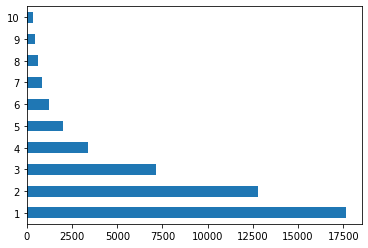

In [33]:
'''
Check number of words in answers 
We need answers which occur in the form of phrases or one word
'''
df['ans_length'].value_counts()[:10].plot(kind='barh')

<AxesSubplot:>

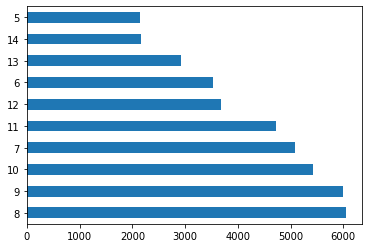

In [34]:
df['ques_length'].value_counts()[:10].plot(kind='barh')

In [35]:
'''
Check the counts of each question type
We only take first 10 characters of string and check occurance of who,what when and where 
since we do not want to include cases where these have not been used in the question context.
Converting the string to lower is a must
'''
df.loc[df['question'].str.lower().str.slice(0, 10).str.contains('when'), 'ques_type'] = 'when' 
df.loc[df['question'].str.lower().str.slice(0, 10).str.contains('who'), 'ques_type'] = 'who'
df.loc[df['question'].str.lower().str.slice(0, 10).str.contains('what'), 'ques_type'] = 'what'
df.loc[df['question'].str.lower().str.slice(0, 10).str.contains('where'), 'ques_type'] = 'where' 

In [41]:
'''
Keep only questions whos answers are in the form of one word or phrases i.e. factoid
'''
df = df[df['ans_length']<=3]
df = df[~df['ques_type'].isna()]



<AxesSubplot:>

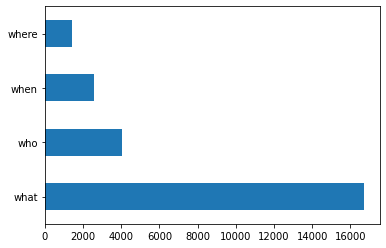

In [45]:
'''
Final counts of questions of each type
'''
df['ques_type'].value_counts().plot(kind='barh')

<AxesSubplot:>

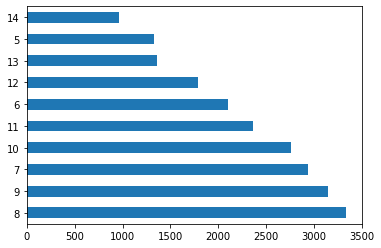

In [53]:
'''
Distribution of length of questions
'''
df['ques_length'].value_counts()[:10].plot(kind='barh')

<AxesSubplot:xlabel='ques_type'>

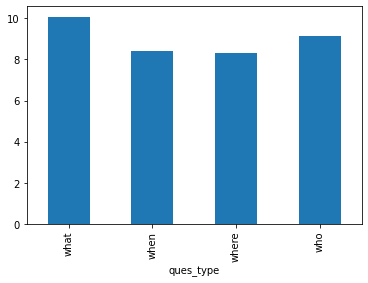

In [55]:
'''
Average length of questions for each type
'''
df.groupby('ques_type', as_index=True)['ques_length'].mean().plot.bar()

In [56]:
df.to_csv("train.csv", index = None)